<a href="https://colab.research.google.com/github/williamsdoug/CTG_RP/blob/master/CTG_RP_Train_Model_Shuffled.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generate Datasets and Train Model


Random selection for Train and Valid without regard for source file

In [2]:
! ls

basic_denoise.py     config_local.py  ctu-uhb-ctgdb  libRP.py	  sample_data
compute_metadata.py  ctg_utils.py     images	     __pycache__  test.py


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import config_local
from config_local import *

In [0]:
import numpy as np
import matplotlib.pyplot as plt

from fastai.vision import *
from fastai.metrics import error_rate

import torch
from torch import nn


import collections
import pprint

In [0]:
from compute_metadata import get_splits, generate_label_file, generate_lists

## Config

In [0]:
tfms=[]
size=64
bs=64
workers=4

path = Path() / 'images'

## Generate Train and Valid Label Files

In [0]:
def generate_label_file(group, image_dir='images', 
                        csv_file='labels.csv', header='fname, label'):
    if csv_file is None:
        results = []
        for v in group.values():
            for label, all_files in v.items():
                for fname in all_files:
                    results.append((os.path.join(image_dir, fname), 1 if label else 0))
        return results
    else:
        with open(os.path.join(image_dir, csv_file), 'wt') as outfile:
            if header:
                print(header, file=outfile)
            for v in group.values():
                for label, all_files in v.items():
                    for fname in all_files:
                        line = '{}, {}'.format(fname, 1 if label else 0)
                        print(line, file=outfile)

In [0]:
train_valid_groups_full = get_splits(image_dir='images', image_file='rp_images_index.json', 
                                     exclude=['_clipped'],
                                     thresh = 7.15)
              
generate_label_file(train_valid_groups_full[0], csv_file='labels.csv')

In [24]:
!ls images/*.csv
#!cat images/labels.csv

images/labels.csv   images/train_2.csv	images/valid_0.csv  images/valid_3.csv
images/train_0.csv  images/train_3.csv	images/valid_1.csv  images/valid_4.csv
images/train_1.csv  images/train_4.csv	images/valid_2.csv


In [25]:
lls = ImageList.from_csv(path, 'labels.csv').split_by_rand_pct(0.2).label_from_df(cols=1).transform(tfms, size=size)
db = lls.databunch(bs=bs, num_workers=workers)#.normalize(imagenet_stats)
db

ImageDataBunch;

Train: LabelList (490 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
0,0,0,0,0
Path: images;

Valid: LabelList (122 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
1,1,0,1,0
Path: images;

Test: None

In [0]:
# train = ImageList.from_csv(path, 'train_0.csv')
# valid = ImageList.from_csv(path, 'valid_0.csv')

# lls = ItemLists(path, train, valid).label_from_df(cols=1).transform(tfms, size=size) 
# db = lls.databunch(bs=bs, num_workers=workers)#.normalize(imagenet_stats)

### Examine Results

In [27]:
print('nClass: {}    classes: {}'.format(db.c, db.classes))
db

nClass: 2    classes: [0, 1]


ImageDataBunch;

Train: LabelList (490 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
0,0,0,0,0
Path: images;

Valid: LabelList (122 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
1,1,0,1,0
Path: images;

Test: None

490 torch.Size([599, 599])


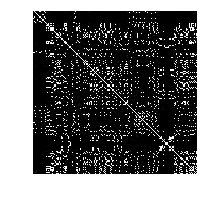

In [30]:
im = lls.train.get(-1)
print(len(lls.train), im.size)
im.show()

## Model

In [0]:
trial_model = nn.Sequential(
    nn.Sequential(
          nn.Conv2d(3,8,5),     # 60 × 60 × 8
          nn.ReLU(),
          nn.AvgPool2d(3, stride=2),    # 29 × 29 × 8
        
          #nn.Dropout(p=0.25),
          nn.Conv2d(8,8,5),         # 25 × 25 × 8
          nn.ReLU(),
          nn.AvgPool2d(3, stride=2),    # 12 × 12 × 8
        
          Flatten()         # 1152
    ),
    # removed model head to compute flatten size
)

In [32]:
trial_learn = Learner(db, trial_model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)
trial_learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 60, 60]          608        True      
______________________________________________________________________
ReLU                 [8, 60, 60]          0          False     
______________________________________________________________________
AvgPool2d            [8, 29, 29]          0          False     
______________________________________________________________________
Conv2d               [8, 25, 25]          1,608      True      
______________________________________________________________________
ReLU                 [8, 25, 25]          0          False     
______________________________________________________________________
AvgPool2d            [8, 12, 12]          0          False     
______________________________________________________________________
Flatten              [1152]               0          False     
______________________________________________________________

In [0]:
mymodel = nn.Sequential(
    nn.Sequential(
          nn.Conv2d(3,8,5),     # 60 × 60 × 8
          nn.ReLU(),
          nn.AvgPool2d(3, stride=2),    # 29 × 29 × 8
        
          #nn.Dropout(p=0.25),
          nn.Conv2d(8,8,5),         # 25 × 25 × 8
          nn.ReLU(),
          nn.AvgPool2d(3, stride=2),    # 12 × 12 × 8
        
          Flatten()         # 1152
    ),
    nn.Sequential(
#           nn.Dropout(p=0.25),
          nn.Linear(1152, 144),
          nn.ReLU(),
          nn.Dropout(p=0.8),
          nn.Linear(144, db.c) 
    )
)

In [0]:
learn = Learner(db, mymodel, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)
learn.summary()
learn.save('initial')

# Train Model

In [35]:
# learn.fit_one_cycle(1, 1e-7)  # learn.fit_one_cycle(1, 0.01)

# learn.save('save-1')

epoch,train_loss,valid_loss,accuracy,time
0,0.692729,0.693551,0.483607,00:04


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


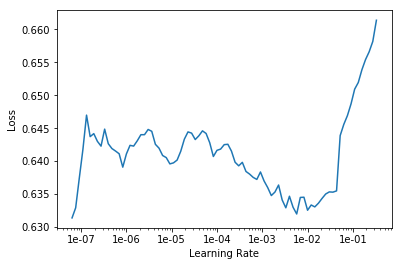

In [39]:
learn.lr_find(start_lr=1e-8, end_lr=1)
learn.recorder.plot()

In [41]:
learn.load('initial')
learn.fit_one_cycle(100, 3e-3)  # learn.fit_one_cycle(1, 0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.648894,0.651624,0.614754,00:04
1,0.644276,0.651220,0.606557,00:03
2,0.640934,0.650894,0.590164,00:04
3,0.639508,0.650522,0.590164,00:04
4,0.637933,0.649971,0.590164,00:04
5,0.636132,0.648370,0.581967,00:03
6,0.634619,0.646566,0.581967,00:04
7,0.635631,0.645335,0.590164,00:03
8,0.631769,0.642472,0.631148,00:03
9,0.629442,0.639290,0.614754,00:04
